In [55]:
import pandas as pd

import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(context="poster", style="dark")

from sklearn import ensemble, feature_extraction, preprocessing
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
#Cheat-sheet (I alphabetized it back in the csv):

data_dict_df = pd.read_excel('Submission Analytics Data Dictionary.xls')
data_dict_df.values

array([['AGENT_CODE', 'Unique identifying code assigned to agency'],
       ['AGENT_CONTACT',
        'Name of agent assigned to submission in Edge (if there are multiple results/agents, this field will display the latest addition/current broker)'],
       ['AGENT_NAME', 'Name of the agency who sent the submission'],
       ['BDP_RENEW_FLAG',
        'Determines if the renewal is happening within Edge or from a different system into Edge'],
       ['BOUND_COUNT',
        'Determines if a submission is bound. 1 = bound; 0 = not bound'],
       ['BOUND_DATE', 'Date the quote was bound in Edge'],
       ['BUSINESS_UNIT_NAME',
        'The business unit to which the submission is sent'],
       ['CLAIM_COUNT', 'Number of claims incurred on bound policy'],
       ['ENDORSEMENT_PREMIUM',
        'Calculates the total premium dollar changes since inception'],
       ['EXP_INCRD',
        'Total dollar amount of all expenses incurred on the policy'],
       ['EXP_PAID',
        'Total dollar a

In [3]:
#OK, let's load our data:

data_df = pd.read_csv('Argo/submission.csv')
pd.set_option('display.max_columns', 500) # this is just to make sure I can get a good preview of the data
pd.set_option('display.max_rows', 100)

# obnoxious CAPs :(
data_df.columns = [ name.lower() for name in data_df.columns.values ]

# data_df.head() # I looked at the data here initially, but commented-out here to save space

/home/alex/anaconda3/lib/python3.4/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (7,39) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [4]:
#checking if there are few unique names among some categories to see if it's worthwhile to create dummy var-s

# print(np.unique(data_df.quoted_count))
print(len(np.unique(data_df.underwriter_name)))
print(len(np.unique(data_df.underwriter_assistant)))
print(len(np.unique(data_df.program)))

#so far so good, although I don't like 364 and 60... they may have to stay numbers anyway

364
60
8


####Let's get rid of some categories that seem accidental (dates and policy or customer names) and repetitive (bands).

In [5]:
# drop extraneous (so far) cols

data_df.drop(['received_count', 'pol_num', 'quotetoboundtime_band', 'received_date',
             'received_day', 'received_day', 'received_year', 'rejected_date', 'quoted_date',
             'quoted_year', 'bound_date', 'pending_date', 'pol_eff_dt', 'pol_exp_dt',
             'previous_policy_num', 'premium_band', 'issue_dt', 'quote_start_date', 'insured_name',
             'quoted_premium_band', 'recdtoquotetime_band', 'recdtorejecttime_band'], 1, inplace=True)
data_df.head()

,agent_name,agent_code,parent_agent_code,parent_agent_name,business_unit_name,operating_unit_name,underwriter_name,renewal_flag,quoted_count,bound_count,reject_count,reject_after_quote_flag,recdtoquotetime,recdtorejecttime,recdtopendingtime,quotetoboundtime,quoted_day,pending_aging_days,policy_premium,reject_reason,sub_reject_reason,bdp_renew_flag,program,claim_count,loss_incrd,loss_paid,exp_incrd,exp_paid,quoted_premium,userrole,minimum_premium_flag,minimum_premium,minimum_override_premium_flag,minimum_override_premium,agent_contact,endorsement_premium,underwriter_assistant,received_to_eff_day,insured_state,submission_no
0,Agent 1,1,1,Parent Agent 1,Contract,Contract,Underwriter 1,N,1,1,0,N,38.92,0,0,0.92,2-MON,0,1975,NaN,NaN,N,PKG-Standard Lines of Business,0,0,0,0,0,1975,Employee,N,0,N,0,Agent Contact 1,-1975,Underwriter Assistant 1,0,Ohio,1
1,Agent 2,2,2,Parent Agent 2,Casualty,General Casualty,Underwriter 2,N,1,1,0,N,1498.92,0,0,41636.60,5-THU,0,8625,NaN,NaN,N,000-Non Programs,0,0,0,0,0,8625,Employee,Y,5500,N,0,Agent Contact 2,500,Underwriter Assistant 2,13,Louisiana,2
2,Agent 3,3,3,Parent Agent 3,Casualty,Industrial Casualty,Underwriter 3,N,1,1,0,N,3001.08,0,0,8328.80,3-TUE,0,23312,NaN,NaN,N,000-Non Programs,0,0,0,0,0,23312,Employee,Y,5500,N,0,Agent Contact 3,0,Underwriter Assistant 3,10,Missouri,3
3,Agent 4,4,4,Parent Agent 4,Casualty,General Casualty,Underwriter 4,Y,1,1,0,N,37265.12,0,0,15747.57,5-THU,0,7625,NaN,NaN,N,000-Non Programs,0,0,0,0,0,7625,Employee,Y,5500,Y,7500,Agent Contact 4,1365,Underwriter Assistant 4,37,Louisiana,4
4,Agent 5,5,5,Parent Agent 5,Contract,Contract,Underwriter 5,Y,1,1,0,N,44.57,0,0,11815.08,2-MON,0,750,NaN,NaN,N,PKG-Standard Lines of Business,0,0,0,0,0,750,Agent Third Party,N,0,N,0,Agent Contact 5,0,Underwriter Assistant 1,15,North Carolina,5


In [6]:
data_df.shape

(108857, 40)

In [7]:
quoted_df = data_df[data_df.quoted_count==1]
quoted_df.shape

(23802, 40)

In [8]:
unquoted_df = data_df[data_df.quoted_count==0]
print(np.unique(unquoted_df.reject_after_quote_flag))
print(np.unique(unquoted_df.reject_count))

['N']
[0 1]


####So, it seems that some customers reject the policy even before they received a quote. While it may be worthwhile to see if they had to wait too long, etc., let's exclude them for now and just focus on trying to predict what made the customers who <b>had</b> been quoted reject the quote.

From here I see two possibilities: group by some categorical variable (e.g., agent ID) and calculate means for everything (including dummy variable) and treat it as a regression problem to predict average rejection rate. I might do that later, time permitting (it's also useful internally to see if some agents have higher rejection rates than others and see why — do they have to deal more with policy A vs. B, etc., or is it about location, etc.?). For now, I'll take the more basic possibility and treat it as a classfication problem and throw different classifiers at it.

Logistic regression has good inference but may not work well with such a large number of predictors. Let's start off with random-forest--derived ensemble method and see if I can get a good model fit; print out the feature importances and then maybe test those in logistic regression.

In [9]:
del(unquoted_df) # conserve the RAM :)

# Let's look again at what we got:
quoted_df.head()

,agent_name,agent_code,parent_agent_code,parent_agent_name,business_unit_name,operating_unit_name,underwriter_name,renewal_flag,quoted_count,bound_count,reject_count,reject_after_quote_flag,recdtoquotetime,recdtorejecttime,recdtopendingtime,quotetoboundtime,quoted_day,pending_aging_days,policy_premium,reject_reason,sub_reject_reason,bdp_renew_flag,program,claim_count,loss_incrd,loss_paid,exp_incrd,exp_paid,quoted_premium,userrole,minimum_premium_flag,minimum_premium,minimum_override_premium_flag,minimum_override_premium,agent_contact,endorsement_premium,underwriter_assistant,received_to_eff_day,insured_state,submission_no
0,Agent 1,1,1,Parent Agent 1,Contract,Contract,Underwriter 1,N,1,1,0,N,38.92,0,0,0.92,2-MON,0,1975,NaN,NaN,N,PKG-Standard Lines of Business,0,0,0,0,0,1975,Employee,N,0,N,0,Agent Contact 1,-1975,Underwriter Assistant 1,0,Ohio,1
1,Agent 2,2,2,Parent Agent 2,Casualty,General Casualty,Underwriter 2,N,1,1,0,N,1498.92,0,0,41636.60,5-THU,0,8625,NaN,NaN,N,000-Non Programs,0,0,0,0,0,8625,Employee,Y,5500,N,0,Agent Contact 2,500,Underwriter Assistant 2,13,Louisiana,2
2,Agent 3,3,3,Parent Agent 3,Casualty,Industrial Casualty,Underwriter 3,N,1,1,0,N,3001.08,0,0,8328.80,3-TUE,0,23312,NaN,NaN,N,000-Non Programs,0,0,0,0,0,23312,Employee,Y,5500,N,0,Agent Contact 3,0,Underwriter Assistant 3,10,Missouri,3
3,Agent 4,4,4,Parent Agent 4,Casualty,General Casualty,Underwriter 4,Y,1,1,0,N,37265.12,0,0,15747.57,5-THU,0,7625,NaN,NaN,N,000-Non Programs,0,0,0,0,0,7625,Employee,Y,5500,Y,7500,Agent Contact 4,1365,Underwriter Assistant 4,37,Louisiana,4
4,Agent 5,5,5,Parent Agent 5,Contract,Contract,Underwriter 5,Y,1,1,0,N,44.57,0,0,11815.08,2-MON,0,750,NaN,NaN,N,PKG-Standard Lines of Business,0,0,0,0,0,750,Agent Third Party,N,0,N,0,Agent Contact 5,0,Underwriter Assistant 1,15,North Carolina,5


In [10]:
np.unique(quoted_df[quoted_df.reject_count==1].bound_count)

array([0, 1])

In [11]:
quoted_df[quoted_df.reject_count==1][quoted_df.bound_count==1]

/home/alex/anaconda3/lib/python3.4/site-packages/pandas/core/frame.py:1819: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


,agent_name,agent_code,parent_agent_code,parent_agent_name,business_unit_name,operating_unit_name,underwriter_name,renewal_flag,quoted_count,bound_count,reject_count,reject_after_quote_flag,recdtoquotetime,recdtorejecttime,recdtopendingtime,quotetoboundtime,quoted_day,pending_aging_days,policy_premium,reject_reason,sub_reject_reason,bdp_renew_flag,program,claim_count,loss_incrd,loss_paid,exp_incrd,exp_paid,quoted_premium,userrole,minimum_premium_flag,minimum_premium,minimum_override_premium_flag,minimum_override_premium,agent_contact,endorsement_premium,underwriter_assistant,received_to_eff_day,insured_state,submission_no
1376,Agent 1,1,1,Parent Agent 1,Contract,Contract,Underwriter 145,N,1,1,1,Y,10.93,565.8,7982432.5,9.9,3-TUE,0,0,Lost,Stayed with incumbent,N,PKG-Standard Lines of Business,0,0,0,0,0,1850,Employee,N,0,N,0,Agent Contact 1,0,Underwriter Assistant 1,0,NaN,1377


I am assuming this guy was not bound ^ (since rejected_count and flags are true). Either way, I am dropping `bound_count` because it just the inverse of `reject_count`.

In [12]:
quoted_df.drop(['bound_count', 'reject_after_quote_flag', 'reject_reason', 'sub_reject_reason'], 1, inplace=True)
# quoted_df.head()

/home/alex/anaconda3/lib/python3.4/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [13]:
quoted_df.quotetoboundtime.describe()

count      23802.000000
mean      493799.530975
std      1901423.584371
min         -357.550000
25%            0.000000
50%            0.000000
75%        21672.900000
max      7999865.500000
Name: quotetoboundtime, dtype: float64

In [14]:
quoted_df[quoted_df.quotetoboundtime < 0].quotetoboundtime.values

array([ -3.37400000e+02,  -2.52770000e+02,  -9.31700000e+01,
        -2.22980000e+02,  -2.84330000e+02,  -1.75830000e+02,
        -1.50200000e+02,  -3.47000000e+02,  -2.01330000e+02,
        -2.48220000e+02,  -3.47220000e+02,  -5.00000000e-02,
        -2.46080000e+02,  -1.59230000e+02,  -3.26330000e+02,
        -3.57550000e+02,  -2.19580000e+02,  -2.38670000e+02])

In [15]:
''' ^ Yeah, I don't know what negative time means. Normally I would treat these as NaNs and try to fill in, but 
since I am interested in predicting what led to rejection or acceptance anyway, I'll just drop these for now.'''

quoted_df.drop(['quotetoboundtime'], 1, inplace=True)
# quoted_df.head()

/home/alex/anaconda3/lib/python3.4/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [16]:
quoted_df.head(1)

,agent_name,agent_code,parent_agent_code,parent_agent_name,business_unit_name,operating_unit_name,underwriter_name,renewal_flag,quoted_count,reject_count,recdtoquotetime,recdtorejecttime,recdtopendingtime,quoted_day,pending_aging_days,policy_premium,bdp_renew_flag,program,claim_count,loss_incrd,loss_paid,exp_incrd,exp_paid,quoted_premium,userrole,minimum_premium_flag,minimum_premium,minimum_override_premium_flag,minimum_override_premium,agent_contact,endorsement_premium,underwriter_assistant,received_to_eff_day,insured_state,submission_no
0,Agent 1,1,1,Parent Agent 1,Contract,Contract,Underwriter 1,N,1,0,38.92,0,0,2-MON,0,1975,N,PKG-Standard Lines of Business,0,0,0,0,0,1975,Employee,N,0,N,0,Agent Contact 1,-1975,Underwriter Assistant 1,0,Ohio,1


In [17]:
cols = quoted_df.columns.tolist()
cols = cols[9:] + cols[:9]
cols

['reject_count',
 'recdtoquotetime',
 'recdtorejecttime',
 'recdtopendingtime',
 'quoted_day',
 'pending_aging_days',
 'policy_premium',
 'bdp_renew_flag',
 'program',
 'claim_count',
 'loss_incrd',
 'loss_paid',
 'exp_incrd',
 'exp_paid',
 'quoted_premium',
 'userrole',
 'minimum_premium_flag',
 'minimum_premium',
 'minimum_override_premium_flag',
 'minimum_override_premium',
 'agent_contact',
 'endorsement_premium',
 'underwriter_assistant',
 'received_to_eff_day',
 'insured_state',
 'submission_no',
 'agent_name',
 'agent_code',
 'parent_agent_code',
 'parent_agent_name',
 'business_unit_name',
 'operating_unit_name',
 'underwriter_name',
 'renewal_flag',
 'quoted_count']

In [18]:
quoted_df = quoted_df[cols]

# just re-arrange to make reject_count be the first column for the next viz
quoted_df.head(1)

,reject_count,recdtoquotetime,recdtorejecttime,recdtopendingtime,quoted_day,pending_aging_days,policy_premium,bdp_renew_flag,program,claim_count,loss_incrd,loss_paid,exp_incrd,exp_paid,quoted_premium,userrole,minimum_premium_flag,minimum_premium,minimum_override_premium_flag,minimum_override_premium,agent_contact,endorsement_premium,underwriter_assistant,received_to_eff_day,insured_state,submission_no,agent_name,agent_code,parent_agent_code,parent_agent_name,business_unit_name,operating_unit_name,underwriter_name,renewal_flag,quoted_count
0,0,38.92,0,0,2-MON,0,1975,N,PKG-Standard Lines of Business,0,0,0,0,0,1975,Employee,N,0,N,0,Agent Contact 1,-1975,Underwriter Assistant 1,0,Ohio,1,Agent 1,1,1,Parent Agent 1,Contract,Contract,Underwriter 1,N,1


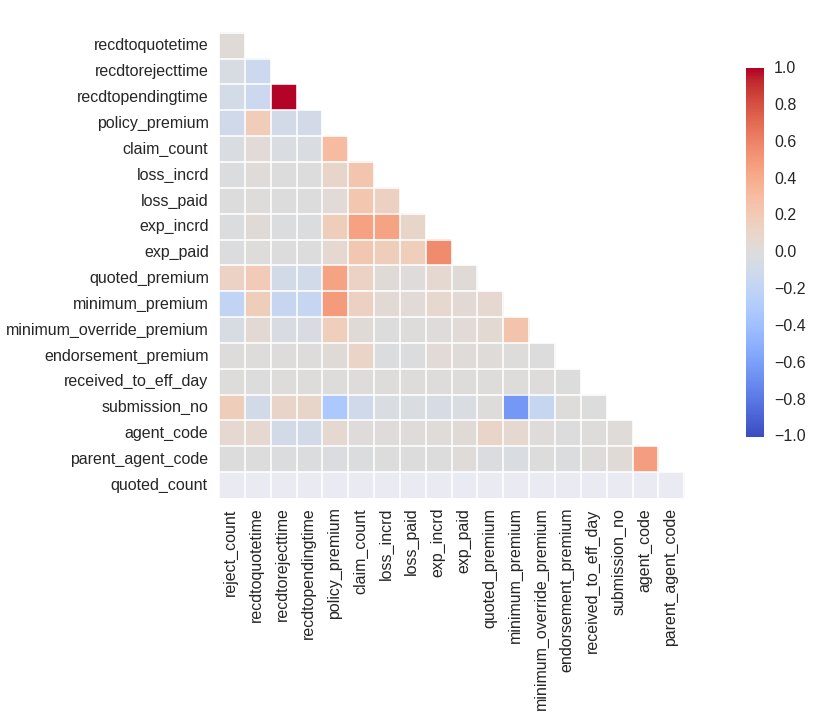

In [19]:
sns.corrplot(quoted_df, annot=False, diag_names=False)

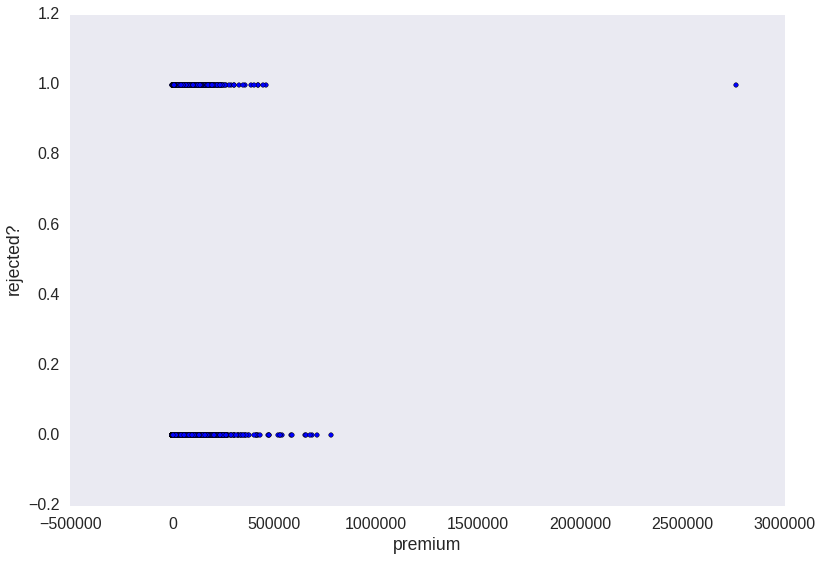

In [28]:
# plt.rcParams['figure.figsize'] = (80.0, 8.0)


sns.set(context='poster', style='dark')
# plt.figure(figsize=(80, 60))
# sns.lmplot('quoted_premium', 'reject_count', quoted_df)

plt.scatter(quoted_df.quoted_premium, quoted_df.reject_count)
plt.ylabel('rejected?')
plt.xlabel('premium')

Let's take out that outlier. (Also, obviously, it's not going to be so simple as premium predicting rejection/acceptance.)

In [30]:
quoted_df[quoted_df.quoted_premium > 1e6]

,reject_count,recdtoquotetime,recdtorejecttime,recdtopendingtime,quoted_day,pending_aging_days,policy_premium,bdp_renew_flag,program,claim_count,loss_incrd,loss_paid,exp_incrd,exp_paid,quoted_premium,userrole,minimum_premium_flag,minimum_premium,minimum_override_premium_flag,minimum_override_premium,agent_contact,endorsement_premium,underwriter_assistant,received_to_eff_day,insured_state,submission_no,agent_name,agent_code,parent_agent_code,parent_agent_name,business_unit_name,operating_unit_name,underwriter_name,renewal_flag,quoted_count
58325,1,19757.68,244830.83,0,3-TUE,0,0,N,000-Non Programs,0,0,0,0,0,2760432,Employee,N,0,N,0,Agent Contact 15,0,Underwriter Assistant 3,106,California,58326,Agent 15,15,4,Parent Agent 4,Casualty,Specialty Primary,Underwriter 41,N,1


In [32]:
quoted_df.drop(58325, inplace=True)

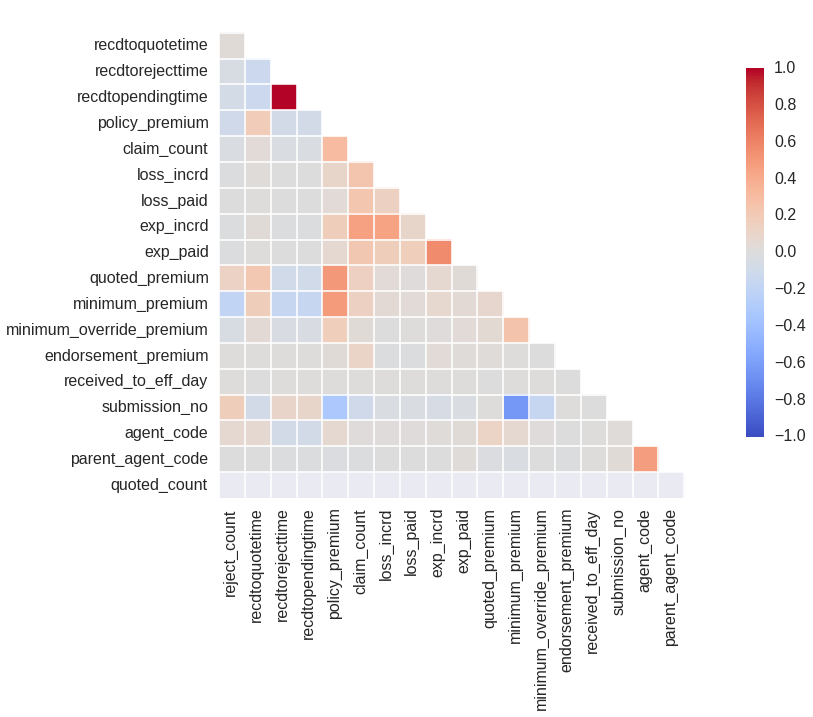

In [41]:
sns.corrplot(quoted_df, annot=False, diag_names=False)

In [43]:
quoted_df.drop(['recdtorejecttime'], 1, inplace=True)

In [44]:
quoted_df.drop(['quoted_count'], 1, inplace=True) # should've done that above

In [72]:
quoted_df.columns.values

array(['reject_count', 'recdtoquotetime', 'recdtopendingtime',
       'quoted_day', 'pending_aging_days', 'policy_premium',
       'bdp_renew_flag', 'program', 'claim_count', 'loss_incrd',
       'loss_paid', 'exp_incrd', 'exp_paid', 'quoted_premium', 'userrole',
       'minimum_premium_flag', 'minimum_premium',
       'minimum_override_premium_flag', 'minimum_override_premium',
       'agent_contact', 'endorsement_premium', 'underwriter_assistant',
       'received_to_eff_day', 'insured_state', 'submission_no',
       'agent_name', 'agent_code', 'parent_agent_code',
       'parent_agent_name', 'business_unit_name', 'operating_unit_name',
       'underwriter_name', 'renewal_flag'], dtype=object)

In [73]:
# after some testing, I decided to take out agent info of any kind

quoted_df.drop(['submission_no', 'agent_contact', 'underwriter_assistant', 'agent_code', 'parent_agent_code', 
                'agent_name', 'parent_agent_name', 'underwriter_name'], 1, inplace=True)

In [167]:
quoted_df.drop(['received_to_eff_day'], 1, inplace=True)

In [168]:
quoted_dummy_df = pd.get_dummies(quoted_df)

# I don't like using agent as a num-s, but there are too many of them for dummy vars, and I don't want to drop them

print('new shape: ', quoted_dummy_df.shape)
quoted_dummy_df.head()

new shape:  (23801, 83)


,reject_count,recdtoquotetime,recdtopendingtime,policy_premium,claim_count,loss_incrd,loss_paid,exp_incrd,exp_paid,quoted_premium,minimum_premium,minimum_override_premium,endorsement_premium,quoted_day_1-SUN,quoted_day_2-MON,quoted_day_3-TUE,quoted_day_4-WED,quoted_day_5-THU,quoted_day_6-FRI,quoted_day_7-SAT,pending_aging_days_0,bdp_renew_flag_N,bdp_renew_flag_Y,program_000-Non Programs,program_98C-Oil and Gas,program_B82-Contractual Warranty Business,program_B90-Railroad Protective Liability,program_C23-Owners And Contractors Protective,program_FO-Farm and Ranch,program_PKG-Standard Lines of Business,userrole_Agent Third Party,userrole_Employee,minimum_premium_flag_N,minimum_premium_flag_Y,minimum_override_premium_flag_N,minimum_override_premium_flag_Y,insured_state_Alabama,insured_state_Alaska,insured_state_Arizona,insured_state_Arkansas,insured_state_California,insured_state_Colorado,insured_state_Connecticut - OFF,insured_state_Connecticut - ON,insured_state_Delaware,insured_state_Florida,insured_state_Georgia,insured_state_Hawaii (Honolulu),insured_state_Idaho,insured_state_Illinois,insured_state_Indiana,insured_state_Iowa,insured_state_Kentucky,insured_state_Louisiana,insured_state_Maine,insured_state_Maryland,insured_state_Massachusetts - OFF,insured_state_Massachusetts - ON,insured_state_Michigan,insured_state_Minnesota,insured_state_Missouri,insured_state_Nebraska,insured_state_New Hampshire,insured_state_New Jersey,insured_state_New York,insured_state_North Carolina,insured_state_North Dakota,insured_state_Ohio,insured_state_Oklahoma,insured_state_Oregon,insured_state_Pennsylvania,insured_state_Rhode Island (Providence),insured_state_South Carolina,insured_state_Tennessee - ON,insured_state_Washington DC,business_unit_name_Casualty,business_unit_name_Contract,operating_unit_name_Contract,operating_unit_name_General Casualty,operating_unit_name_Industrial Casualty,operating_unit_name_Specialty Primary,renewal_flag_N,renewal_flag_Y
0,0,38.92,0,1975,0,0,0,0,0,1975,0,0,-1975,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0
1,0,1498.92,0,8625,0,0,0,0,0,8625,5500,0,500,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0
2,0,3001.08,0,23312,0,0,0,0,0,23312,5500,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0
3,0,37265.12,0,7625,0,0,0,0,0,7625,5500,7500,1365,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1
4,0,44.57,0,750,0,0,0,0,0,750,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1


In [169]:
Y_rej = quoted_dummy_df.reject_count.values
X_rej = quoted_dummy_df.drop(['reject_count'], 1, inplace=False).values

In [297]:
from sklearn.preprocessing import MinMaxScaler

X_scaler = MinMaxScaler()

X_scaler.fit(X_rej)
X_scaled = X_scaler.transform(X_rej)

In [171]:
print(X_rej.shape)
Y_rej.shape

(23801, 82)


(23801,)

In [298]:
from sklearn.naive_bayes import GaussianNB
gauss_nb = GaussianNB()

# gauss_nb.fit(X_rej, Y_rej)
# print("done fitting")

scores = cross_validation.cross_val_score(gauss_nb, X_scaled, Y_rej, cv=5, n_jobs=-1)
print('scores:\t', scores)
print("average score:\t", np.mean(scores))

scores:	 [ 0.99663936  0.99852941  0.42079832  0.32857143  0.3210084 ]
average score:	 0.613109384901


In [299]:
import time

from sklearn.ensemble import GradientBoostingClassifier

params = {'max_depth':20, 'subsample':0.5, 'verbose':0, 'random_state':0,
        'min_samples_split':20, 'min_samples_leaf':20, 'max_features':'sqrt',
        'n_estimators': 1000, 'learning_rate': 0.01}

gbc_0 = GradientBoostingClassifier(**params)


print("start fitting... ", time.ctime().split()[3])

scores = cross_validation.cross_val_score(gbc_0, X_scaled, Y_rej, cv=5, n_jobs=-1)
print('scores:', scores)
print('mean score:', np.mean(scores))

start fitting...  21:51:53
scores: [ 0.92249527  0.92310924  0.91281513  0.91638655  0.91554622]
mean score: 0.918070483392


### Lookin' good...

In [300]:
gbc = GradientBoostingClassifier(**params) # I prob-ly can just use gbc_0. whatever.
gbc.verbose = 1

print("start fitting... ", time.ctime().split()[3])
gbc.fit(X_scaled, Y_rej)
print("stop fitting... ", time.ctime().split()[3])

start fitting...  21:53:32
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.5394           0.0026            2.45m
         2           0.5363           0.0021            1.98m
         3           0.5392           0.0023            1.61m
         4           0.5486           0.0020            1.50m
         5           0.5473           0.0021            1.50m
         6           0.5311           0.0021            1.48m
         7           0.5294           0.0020            1.46m
         8           0.5295           0.0019            1.46m
         9           0.5308           0.0020            1.47m
        10           0.5249           0.0018            1.44m
        20           0.5042           0.0016            1.45m
        30           0.4900           0.0012            1.43m
        40           0.4779           0.0010            1.42m
        50           0.4784           0.0008            1.40m
        60           0.4564           0.00

###Random forests are resistant to over-fitting, so the last few hundred epochs are ok...

In [301]:
cols = quoted_dummy_df.drop(['reject_count'], 1, inplace=False).columns.values
cols

feat_imports = dict(zip(cols, gbc.feature_importances_))
import operator
feats_sorted = sorted(feat_imports.items(), key=operator.itemgetter(1), reverse=True)

In [179]:
def plot_feats(cols, feats_, num=10):
    feat_imports = dict(zip(cols, feats_))
    import operator
    feats_sorted = sorted(feat_imports.items(), key=operator.itemgetter(1), reverse=True)
    
    
    labels = list(zip(*feats_sorted))[0][:num]
    vals = list(zip(*feats_sorted))[1][:num]

    labels = list(reversed(labels))
    vals = list(reversed(vals))

    fig, ax = plt.subplots()
    ind = np.arange(len(vals))
    width = 0.75
    ax.barh(ind, vals)
    ax.set_yticks(ind+width/2)
    ax.set_yticklabels(labels);
    plt.xlabel('relative importance');

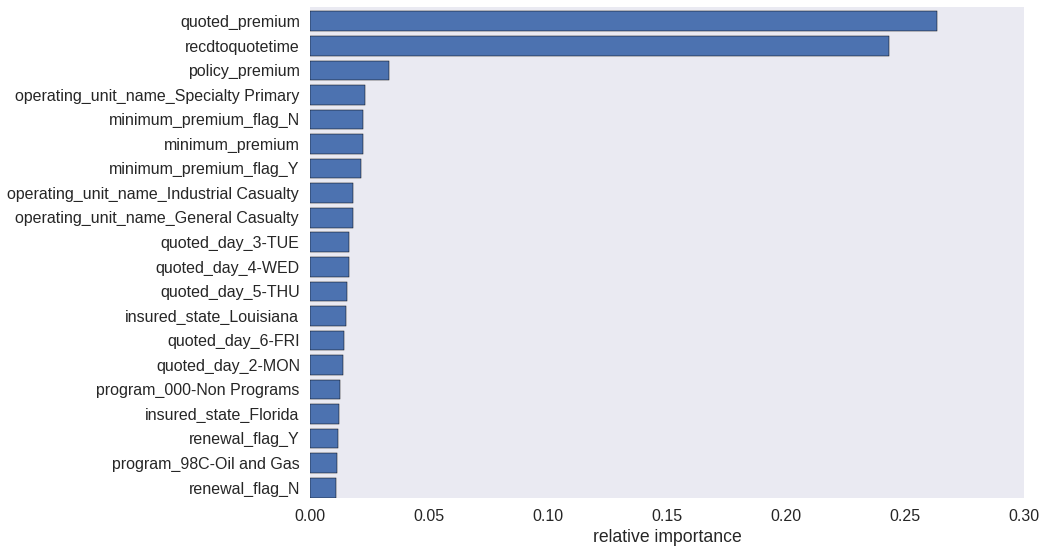

In [303]:
plot_feats(cols, gbc.feature_importances_, 20)